QB RMSE: 0.13775674672025548
QB R2: 0.7775675244544786
Cross-validated RMSE: 0.145 ± 0.009
Cross-validated R²: 0.761 ± 0.033


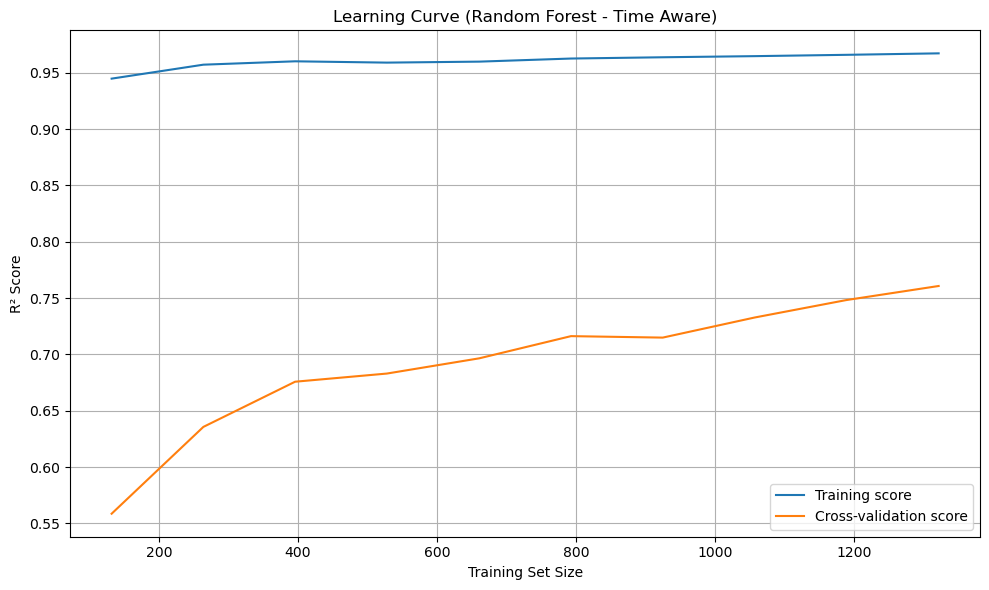

Top 10 Feature Importances:
cpoe                    0.224758
pass_touchdowns         0.184261
third_down_failed       0.097354
pass_yards              0.068633
interceptions           0.055855
sack                    0.038078
third_down_converted    0.024470
fumble_lost             0.021947
first_down_pass         0.020839
fourth_down_failed      0.018765
dtype: float64


In [5]:
# =====================================================
# 版本：time_split_model.py（有時間性控制，預測任務用）
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load QB data
qb = pd.read_csv("dat/qb_stats.csv")

# Sort by time to simulate real game sequence
qb = qb.sort_values(by=['gsis_id', 'season', 'week'])

# Create rolling average features (last 3 games)
qb['rolling_pass_yards'] = qb.groupby('gsis_id')['pass_yards'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
qb['rolling_completions'] = qb.groupby('gsis_id')['completions'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
qb['rolling_pass_tds'] = qb.groupby('gsis_id')['pass_touchdowns'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
qb['rolling_interceptions'] = qb.groupby('gsis_id')['interceptions'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)

# Split based on week number: train on week <= 10, test on week > 10
train_data = qb[qb['week'] <= 10].copy()
test_data = qb[qb['week'] > 10].copy()

# Feature selection and preprocessing
train_features = train_data.drop(columns=['avg_epa','gsis_id', 'position', 'depth_chart_position', 'full_name', 'total_epa', 'third_down_rate', 'fourth_down_rate'])
train_features = pd.get_dummies(train_features, columns=['team'])
train_features['birth_date'] = pd.to_datetime(train_features['birth_date'])
train_features['birth_year'] = train_features['birth_date'].dt.year
train_features = train_features.drop(columns=['birth_date'])
train_features = train_features.dropna()
y_train = train_data.loc[train_features.index, 'avg_epa']

# Process test features before alignment
test_features = test_data.drop(columns=['avg_epa','gsis_id', 'position', 'depth_chart_position', 'full_name', 'total_epa', 'third_down_rate', 'fourth_down_rate']).copy()
test_features = pd.get_dummies(test_features, columns=['team'])
test_features['birth_date'] = pd.to_datetime(test_features['birth_date'])
test_features['birth_year'] = test_features['birth_date'].dt.year
test_features = test_features.drop(columns=['birth_date'])
test_features = test_features.dropna()

# Align test features with training columns
train_features, test_features = train_features.align(test_features, join='left', axis=1, fill_value=0)


# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_features, y_train)

# Predict and evaluate
y_pred = rf_model.predict(test_features)
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
print("QB RMSE:", rmse(y_test, y_pred))
print("QB R2:", r2_score(y_test, y_pred))

# Cross-validation on training set only
cv_rmse_scores = cross_val_score(rf_model, train_features, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_r2_scores = cross_val_score(rf_model, train_features, y_train, cv=5, scoring='r2')
print(f"Cross-validated RMSE: {-cv_rmse_scores.mean():.3f} ± {cv_rmse_scores.std():.3f}")
print(f"Cross-validated R²: {cv_r2_scores.mean():.3f} ± {cv_r2_scores.std():.3f}")

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_model,
    train_features, y_train,
    cv=5,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve (Random Forest - Time Aware)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=train_features.columns).sort_values(ascending=False)
print("Top 10 Feature Importances:")
print(feature_importance.head(10))


In [6]:
test_features.columns

Index(['season', 'week', 'height', 'weight', 'years_exp', 'rookie_year',
       'entry_year', 'draft_number', 'pass_attempts', 'air_yards',
       'first_down_pass', 'rush_attempts', 'rushing_yards', 'rush_touchdowns',
       'first_down_rush', 'third_down_converted', 'third_down_failed',
       'fourth_down_converted', 'fourth_down_failed', 'fumble',
       'fumble_forced', 'fumble_not_forced', 'tackled_for_loss', 'fumble_lost',
       'sack', 'penalties', 'penalty_yards', 'qb_dropback', 'cpoe',
       'avg_time_to_throw', 'avg_completed_air_yards',
       'avg_intended_air_yards', 'avg_air_yards_differential',
       'aggressiveness', 'max_completed_air_distance',
       'avg_air_yards_to_sticks', 'pass_yards', 'pass_touchdowns',
       'interceptions', 'completions', 'completion_percentage',
       'expected_completion_percentage',
       'completion_percentage_above_expectation', 'avg_air_distance',
       'max_air_distance', 'rolling_pass_yards', 'rolling_completions',
       'rol